## 4. Production, Findings and Limitations

## Content
- [Importing Libraries and Dataset](#Importing-Libraries-and-Dataset)
- [Model Selection](#Model-Selection)
- [Production Model](#Production-Model)
- [Findings / Model Interpretation](#Findings-/-Model-Interpretation)
- [Limitations](#Limitations)
- [References](#References)

## Importing Libraries and Dataset

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import regex as re
import requests
from lxml import html
import getpass
from googletrans import Translator

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import unicodedata

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jiana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Importing libraries
from mlxtend.preprocessing import DenseTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
import pickle

In [3]:
test = pd.read_csv('../datasets/shopee.csv')

In [4]:
test.target_variable.value_counts()

1    190
0    186
Name: target_variable, dtype: int64

In [5]:
X_test = test.text
y_test = test.target_variable

In [6]:
# Our scorer based on accuracy_score
scorers = {'precision_score': make_scorer(precision_score),
           'recall_score': make_scorer(recall_score),
           'accuracy_score': make_scorer(accuracy_score),
           'f1_score': make_scorer(f1_score),
           'roc_auc_score': make_scorer(roc_auc_score, needs_threshold=True)
          }

#make a function that prints evaluation metrics score
def evaluation_metrics(model):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    
    print(f'Model sensitivity is : {sensitivity}')
    print(f'Model specificity is : {specificity}')
    print(f'Model f1 score is : {(2*sensitivity*precision)/(sensitivity+precision)}')
    model_proba = [i[1] for i in model.predict_proba(X_test)]
    print('ROC_AUC score on actual data: {}'.format(round(roc_auc_score(y_test, model_proba), 4)))
    print('\n\nClassification report :\n', classification_report(y_test, y_pred),'\n')
    print(pd.DataFrame({'Pred Negative' : [tn,fn], 'Pred Positive' : [fp,tp]}, index = ['Actual Negative','Actual Postitive']))

#for final model section:
#make a function that prints all classification metrics, AUC-ROC + TN, FP, FN, TP
def all_metrics(model):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("True Negatives: " + str(tn))
    print("False Positives: " + str(fp))
    print("False Negatives: " + str(fn))
    print("True Positives: " + str(tp))
    print()
    print('--------------------------------')
    print()
    print('Accuracy: {}'.format(round(accuracy_score(y_test, y_pred), 4)))
    print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
    print('Precision: {}'.format(round(precision_score(y_test, y_pred), 4)))
    print('Recall: {}'.format(round(recall_score(y_test, y_pred), 4)))
    print('Specificity: {}'.format(round(tn/(tn+fp),4)))
    print(f'Model f1 score is : {(f1_score(y_test, y_pred))}')
    #get roc auc score
    model_proba = [i[1] for i in model.predict_proba(X_test)]
    print('ROC_AUC score on actual data: {}'.format(round(roc_auc_score(y_test, model_proba), 4)))

## Model Selection

| Model| Train's Acc| Val Acc| Score Difference|Sensitivity|Specificity|Validation's ROC_AUC
|----|----|----|----|----|----|----|
| K Nearest Neighbor (Baseline)|0.7534|0.67609|0.07731|0.9412|0.2025|0.6402
| Multinomial Naive Bayes|0.8243|0.8239|0.0004|0.8833|0.7178|0.8791
| Logistic Regression|0.8337|0.8349|-0.0011|0.9018|0.7152|0.8978
| Support Vector Machine||| | ||
| Random Forest|0.7803|0.785|-0.0046|0.8254|0.7127|0.8487
| XGBoost|0.7298|0.7293|0.0005|0.9957|0.2533|0.8637

Since employers want to find out what are the factors of an interview process that could lead to both a positive and negative interview experience, our model selection is evaluated based on accuracy. Businesses will use our finding to train their HR and hiring managers to avoid factors that lead to negative interview experience and adopt factors that lead to positive interview experience.

The production model will have a accuary and ROC-AUC closest to 1 among all other models. For our optimization parameter, accuracy was selected as we want value both positive and negative sentiment findings. We also based our selection on ROC-AUC score as we do not have a balanced dataset.

We have trained and fitted k nearest neighbor model as benchmark model and multinomial naive bayes, logistic regression, support vector classifier, random forest classifier and XGBoost classifier.

Looking at the scores for all models, it appears that top performing model is the Logistic regression model. It out performs the benchmark for both accuracy and ROC-AUC scores. The model does not over fit as the train accuracy does not out weigh the validation accuracy. The closest model to the logistic regression is the multinomial naive bayes. The accuracy and AUC-ROC socre of the logistic regression is very close to the logistic regression model.

## Production Model

In [7]:
logreg = pickle.load(open('../saved_models/logreg.sav','rb'))

In [24]:
evaluation_metrics(logreg)

Model sensitivity is : 0.8894736842105263
Model specificity is : 0.6290322580645161
Model f1 score is : 0.7897196261682243
ROC_AUC score on actual data: 0.8143


Classification report :
               precision    recall  f1-score   support

           0       0.85      0.63      0.72       186
           1       0.71      0.89      0.79       190

    accuracy                           0.76       376
   macro avg       0.78      0.76      0.76       376
weighted avg       0.78      0.76      0.76       376
 

                  Pred Negative  Pred Positive
Actual Negative             117             69
Actual Postitive             21            169


In [25]:
all_metrics(logreg)

True Negatives: 117
False Positives: 69
False Negatives: 21
True Positives: 169

--------------------------------

Accuracy: 0.7606
Misclassification rate: 0.2394
Precision: 0.7101
Recall: 0.8895
Specificity: 0.629
Model f1 score is : 0.7897196261682243
ROC_AUC score on actual data: 0.8143


| Production Model|Result Acc|Sensitivity|Specificity|f1 score|ROC_AUC
|----|---- |----  |---- |----|----|
| Logistic Regression|0.7606|0.8895|0.629|0.7897|0.8143

**ROU-AUC Curve**

In [10]:
pred_proba = [i[1] for i in logreg.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
0,1,0.592146
1,1,0.796532
2,1,0.889780
3,0,0.290251
4,0,0.009960
...,...,...
371,1,0.136898
372,0,0.140396
373,1,0.773773
374,0,0.903373


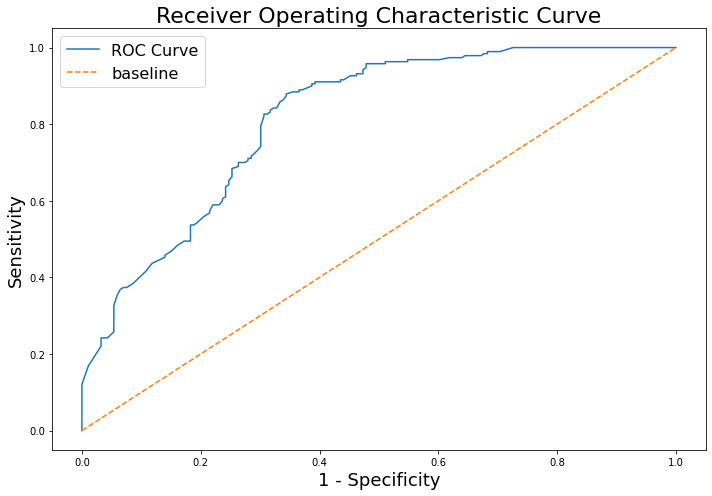

In [11]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

plt.tight_layout()

In [12]:
roc_auc_score(y_test, [i[1] for i in logreg.predict_proba(X_test)])


0.8143322014714205

## Findings / Model Interpretation

**Example of an interview review**

In [13]:
X_test[3]

'applied online heard back within month first hr screening asked finish timed python sql test fairly easy passing technical test interviewed manager worst person ever interviewed hopefully rejected work'

**Actual sentiment is negative**

In [14]:
test.loc[3]['target_variable']

0

**Raw text**

In [15]:
test.loc[3]['interview']

"Applied online, heard back within a month for a first round HR screening interview. Then I was asked to finish a timed Python/SQL test which was fairly easy. After passing the technical test, I interviewed with the Manager. He was the worst person I've ever interviewed with. Hopefully he rejected me, so that I don't have to work with him."

**Model sentiment prediction**

In [16]:
if logreg.predict([X_test[3]])[0] == 0:
    print('Negative Experience')
else:
    print("Positive Experience")

Negative Experience


**Negative Shopee Interview Reviews**

In [17]:
print(test.iloc[4]['interview'],'\n')
print(test.iloc[24]['interview'],'\n')
print(test.iloc[29]['interview'],'\n')
print(test.iloc[41]['interview'],'\n')
print(test.iloc[300]['interview'])

The entire interview process was very disrespectful. They don't ask for your free time and simply give you a time. During the interview, they can be up to 30 minutes late! They don't seem to have much good things to say about the company too. A senior manager said work environment is very stressful. 

Took less than 10 mins after waiting for more than a half-hour. The recruiter seemed very tired. She was working with her laptop while I introduce myself and didn't even give a glance. She didn't ask any work-relevant questions. 

Heard back over a month after applying, went through 3 rounds of interviews didn't make it to the last round. Tedious process for an entry-level position. Standard interview questions not too hard. Recruiters were pleasant, hiring manager didn't seem to be interested, felt like they already had an answer. 

One technical round. The interviewer provided a false link at the beginning. The interviewer does not even know Java and he kept asking how to design a dynam

**Positive Shopee Interview Reviews**

In [18]:
print(test.iloc[2]['interview'],'\n')
print(test.iloc[15]['interview'],'\n')
print(test.iloc[20]['interview'])

The recruiter is very nice and she will explain to you how the company views the most for this position. Phone interview is not difficult and then she directly gives me the chance for a 2nd round test interview. The test interview is about 1.5 hrs and the Python&SQL questions are very basic. 

Phone interview with HR first then direct interview with the cat managers. both interviews were quite fast, within 30 minutes, i think the phone interview was shorter and the hr person was very friendly 

HR Manager was friendly and provided information before the interview took place. There was a better understanding of the happenings and the overall reputation of the company at present. The questions were as expected (i.e. tell me more about yourself, why are you applying for Shopee, etc. )


**Keywords highly correlated to negative or positive review**

In [19]:
log_coef = pd.DataFrame(logreg.named_steps['log'].coef_,
             columns = logreg.named_steps['cvec'].get_feature_names()).rename(
    index={0:'Coefficients'}).T

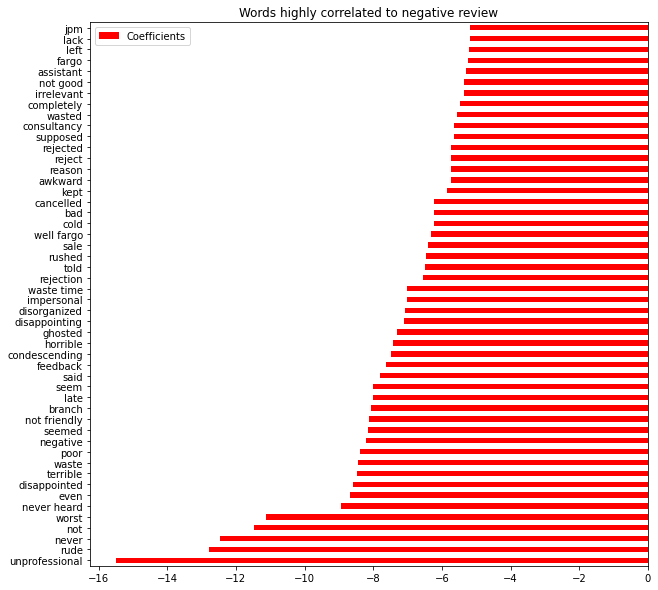

In [20]:
log_coef.sort_values(by='Coefficients', ascending = True)[:50].plot(kind = 'barh',figsize = [10,10], color = 'red').set_title('Words highly correlated to negative review');

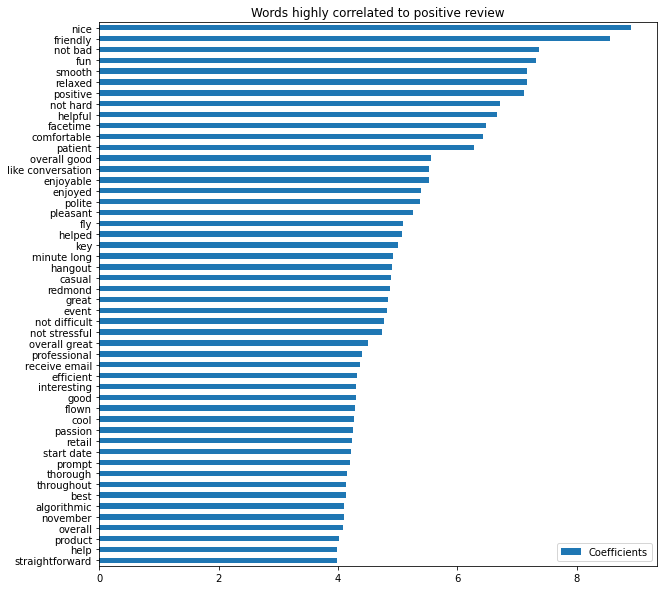

In [21]:
log_coef.sort_values(by='Coefficients', ascending = False)[:50][::-1].plot(kind = 'barh',figsize = [10,10]).set_title('Words highly correlated to positive review');

## Limitations

In [22]:
test.iloc[30]['interview']

'They have a very extensive hiring process, I had to go through multiple interviews for an entry-level position. However, the process for my case was fast, the interview intervals happened in the span of a week or immediately the next day.'

In [23]:
if logreg.predict([test.iloc[30]['interview']])[0] == 0:
    if test.iloc[30]['target_variable']==1:
        print("Actual sentiment : Positive Experience")
    else:
        print("Actual sentiment : Negative Experience")
    print('Model Predict : Negative Experience')
else:
    print("Model Predict : Positive Experience")

Actual sentiment : Positive Experience
Model Predict : Negative Experience


After the model predicts the results, there is still a need for someone to review and validate if certain predictions makes sense. One example is the one above where the reviewer mentioned that the hiring process was extensive and there were multiple rounds, however the process was fast. Perhaps our model picked up more negativity than positivity and as such gave it a negative sentiment as prediction.

As for the limitations, our model is fitted with sentences that were scrapped from glassdoor only. As such, the model analysis is limited to the corpus of texts obtained. Any words that are new to the corpus will not be considered when doing vectorizing transformation and prediction. Another limitation is that our model is only able to pick up english words. If the review is in another language, our model is not able to accurately predict the sentiment.

Our logistic model assumes linear separability between different texts. However, in reality, texts or comments are not exactly linearly separable. At the same time, Naive Bayes model assumes independence between features. Texts or comments may not be independent in fact

Our analysis is limited to the generic positive or negative experience and some of the key words with high coefficients tend to be very subjective and scalable. For instance, nice is the word that has the highest coefficient for positive experience, however it is very subjective and there are too many variations of nice.

## References

- https://www.glassdoor.sg/Interview/Amazon-Interview-Questions-E6036.htm
- https://www.glassdoor.sg/Interview/Apple-Interview-Questions-E1138.htm
- https://www.glassdoor.sg/Interview/Google-Interview-Questions-E9079.htm
- https://www.glassdoor.sg/Interview/Facebook-Interview-Questions-E40772.htm
- https://www.glassdoor.sg/Interview/Microsoft-Interview-Questions-E1651.htm
- https://www.glassdoor.sg/Interview/Walmart-Interview-Questions-E715.htm
- https://www.glassdoor.sg/Interview/Accenture-Interview-Questions-E4138.htm
- https://www.glassdoor.sg/Interview/Dyson-Interview-Questions-E214340.htm
- https://www.glassdoor.sg/Interview/Wells-Fargo-Interview-Questions-E8876.htm
- https://www.glassdoor.sg/Interview/Netflix-Interview-Questions-E11891.htm
- https://www.glassdoor.sg/Interview/Tesla-Interview-Questions-E43129.htm
- https://www.glassdoor.sg/Interview/J-P-Morgan-Interview-Questions-E145.htm
- https://www.glassdoor.sg/Interview/Bloomberg-L-P-Interview-Questions-E3096.htm
- https://www.glassdoor.sg/Interview/LinkedIn-Interview-Questions-E34865.htm
- https://www.glassdoor.sg/Interview/eBay-Interview-Questions-E7853.htm
- https://www.glassdoor.sg/Interview/PayPal-Interview-Questions-E9848.htm
- https://www.glassdoor.sg/Interview/HubSpot-Interview-Questions-E227605.htm
- https://www.glassdoor.sg/Interview/DocuSign-Interview-Questions-E307604.htm
- https://www.glassdoor.sg/Interview/NVIDIA-Interview-Questions-E7633.htm
- https://www.glassdoor.sg/Interview/Oracle-Interview-Questions-E1737.htm
- https://www.glassdoor.sg/Interview/Uber-Interview-Questions-E575263.htm
- https://www.glassdoor.sg/Interview/Twitter-Interview-Questions-E100569.htm
- https://www.glassdoor.sg/Interview/Lyft-Interview-Questions-E700614.htm
- https://www.glassdoor.sg/Interview/Pinterest-Interview-Questions-E503467.htm
- https://www.glassdoor.sg/Interview/Airbnb-Interview-Questions-E391850.htm
- https://www.glassdoor.sg/Interview/Yelp-Interview-Questions-E43314.htm
- https://www.glassdoor.sg/Interview/Booking-com-Interview-Questions-E256653.htm
- https://www.glassdoor.sg/Interview/Groupon-Interview-Questions-E301291.htm
- https://www.glassdoor.sg/Interview/TikTok-Interview-Questions-E2230881.htm
- https://www.glassdoor.sg/Interview/ByteDance-Interview-Questions-E1624196.htm
- https://www.glassdoor.sg/Interview/Shopee-Interview-Questions-E1263091.htm